# NPZ (nutrient-phytoplankton-zooplankton) model

Exploring a three component ecosystem model.

### Exercises
1. Choose a parameter, make a prediction about how that parameter will alter the model, then systematically test the results of changing that parameter.
2. Experiment with changing the functional form of zooplankton grazing. What differences do you notice?
3. Try to "blow up" the model. Take notes on how to make the model attain unrealistic values (e.g. negative concentrations, or total mass of nitrogen is not conserved).

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt

## Select parameters and zooplankton predation type 

#### Parameter values

Default values from Franks et al. (1986):

`
Vm = 2.      # max phtyoplankton growth rate
Rm = 1.5     # max zooplankton ingestion rate
ks = 1.      # half-saturation constant for phytoplankton N uptake 
m = 0.1      # phytoplankton mortality
kg = 1.      # grazing half saturation or (1/Ivlev constant)
lmbda = 0.2  # unassimilated phytoplankton fraction
g = 0.2      # zooplankton mortality
`

In [2]:
Vm = 2.      # max phtyoplankton growth rate
Rm = 1.5     # max zooplankton ingestion rate
ks = 1.      # half-saturation constant for phytoplankton N uptake 
m = 0.1      # phytoplankton mortality
kg = 1.      # grazing half saturation or (1/Ivlev constant)
lmbda = 0.2  # unassimilated phytoplankton fraction
g = 0.2      # zooplankton mortality

#### Zooplankton predation functional type

Options:
* `'M-M'` (Michaelis-Menten, *default*)

$$ I = R_m \frac{P}{k_g+P}Z $$

* `'quadratic'`

$$ I = R_m \frac{P^2}{k_g^2+P^2}Z $$

* `'Ivlev'`

$$ I = R_m\left[1-\exp(-k_g^{-1}P) \right]Z $$

* `'M-P'` (Mayzaud-Poulet)

$$ I = R_m k_g^{-1}P \left[1-\exp(-k_g^{-1}P) \right]Z $$

In [3]:
predation_type = 'M-P' 

## Define time step and initial conditions

In [4]:
dt = 0.0001 # time step [days]
t = np.arange(0,5,dt)

# initialize arrays of NaNs for all times
P = np.nan*t # phytoplankton
N = np.nan*t # nitrate
Z = np.nan*t # zooplankton

Initial conditions at time $t = 0$

In [5]:
P[0] = 1
N[0] = 3
Z[0] = 1

## Zooplankton ingestion function

Zooplankton specific ingestion rate as a function of phytoplankton concentration. This is a functional relationship defined by the model parameters, and does not change with time.

In [6]:
def ingestion(P,Rm,predation_type):
    if predation_type == 'quadratic':
        I = P**2/(kg**2+P**2)
    elif predation_type == 'Ivlev':
        I = 1-np.exp(-kg**-1*P) 
    elif predation_type == 'M-P':
        I = kg**-1*P*(1-np.exp(-kg**-1*P))
    else:
        I = P/(kg+P)
    return I

<IPython.core.display.Javascript object>


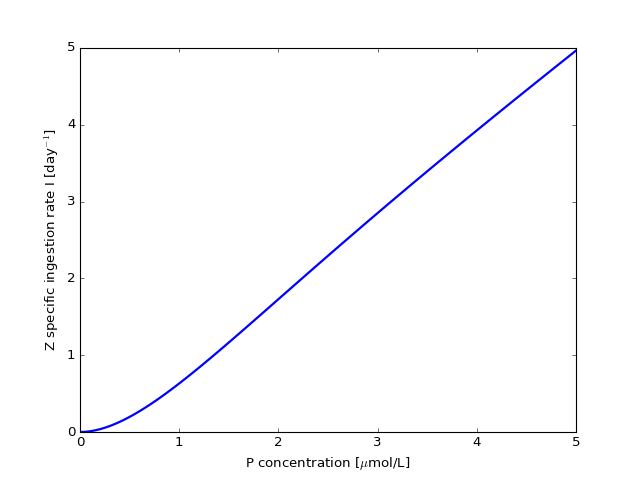

In [7]:
NT = P[0]+N[0]+Z[0]
Pf = np.linspace(0,NT,100)
If = ingestion(Pf,Rm,predation_type)

plt.figure()
plt.plot(Pf,If,lw=2)
plt.xlabel('P concentration [$\mu$mol/L]')
plt.ylabel('Z specific ingestion rate I [day$^{-1}$]')

## Phytoplankton growth function

Phtyoplankton specific growth rate as a function of nutrient concentration. This is a functional relationship defined by the model parameters, and does not change with time.

In [8]:
def phyto_growth_rate(N,Vm,ks):
    mu = Vm*N/(ks+N) # growth rate [day^-1]
    return mu

<IPython.core.display.Javascript object>


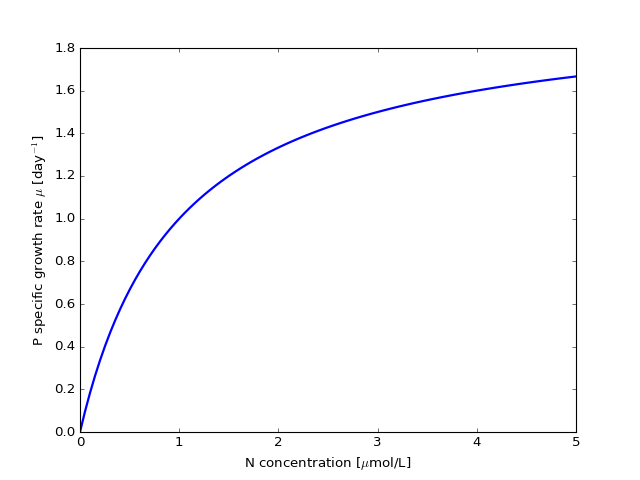

In [9]:
Nf = np.linspace(0,NT,100)
muf = phyto_growth_rate(Nf,Vm,ks)

plt.figure()
plt.plot(Nf,muf,lw=2)
plt.xlabel('N concentration [$\mu$mol/L]')
plt.ylabel('P specific growth rate $\mu$ [day$^{-1}$]')

## Model calculations

Starting from initial conditions and using a loop to step forward in time (Euler's method).

In [10]:
for i,time in enumerate(t[1:]):   
    prod = P[i]*phyto_growth_rate(N[i],Vm,ks) # production rate, dP/dt [cells L^-1 day^-1]
    remin = P[i]*m
    grazing = ingestion(P[i],Rm,predation_type)*Z[i]
    zmort = g*Z[i]
    
    P[i+1] = P[i] + (prod - remin - grazing)*dt
    N[i+1] = N[i] + (-prod + remin + zmort + lmbda*grazing)*dt
    Z[i+1] = Z[i] + ((1-lmbda)*grazing - zmort)*dt

## Time series plots of nitrogen, phytoplankton and zooplankton

<IPython.core.display.Javascript object>


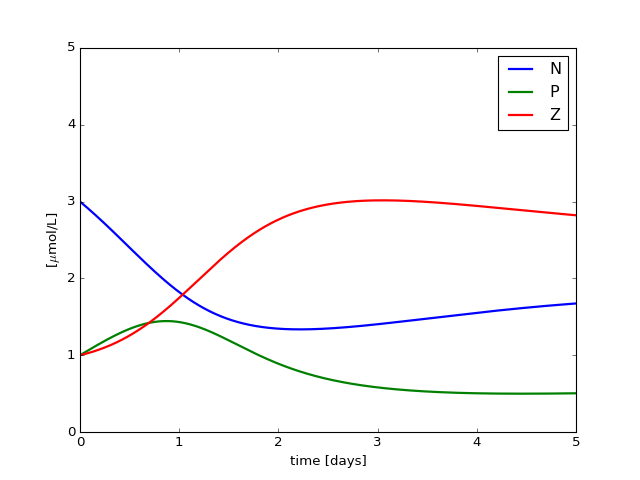

In [11]:
plt.figure()
plt.plot(t,N,color='b',lw=2)
plt.plot(t,P,color='g',lw=2)
plt.plot(t,Z,color='r',lw=2)
plt.ylim([0,NT])
plt.xlabel('time [days]')
plt.ylabel('[$\mu$mol/L]')
plt.legend(['N','P','Z'],loc='best')

## Phase plane diagram of phytoplankton vs. zooplankton

<IPython.core.display.Javascript object>


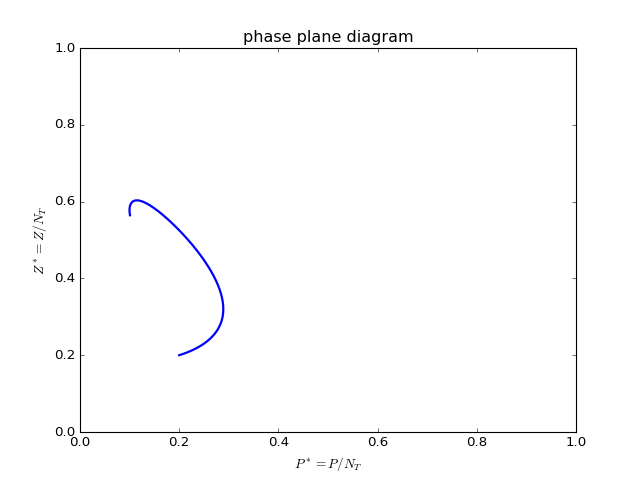

In [12]:
plt.figure()
plt.plot(P/NT,Z/NT,lw=2)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$P^* = P/N_T$')
plt.ylabel('$Z^* = Z/N_T$')
plt.title('phase plane diagram')